## Install relevant libraries

opencv
keras
numpy
matplotlib
tensorflow 2.0.0
 


In [69]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import pickle

## Load Data

In [83]:
########################
path = 'MyData'
testRatio = 0.2
valRatio = 0.2
imageDimensions = (32,32,3)

batchSizeVal = 50
epochsVal = 10
stepsPerEpoch = 2000
########################
images = []
classNo = []
myList = os.listdir(path)
print("Total Number of Classes Detected", len(myList))
noOfClasses = len(myList)
print("Importing Classes...")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x, end=" ")
print("\n",len(images))

Total Number of Classes Detected 10
Importing Classes...
0 1 2 3 4 5 6 7 8 9 
 21555


In [84]:
images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)

(21555, 32, 32, 3)
(21555,)


## Splitting Data

In [85]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=0.2, random_state = 42)
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(13795, 32, 32, 3)
(4311, 32, 32, 3)
(3449, 32, 32, 3)


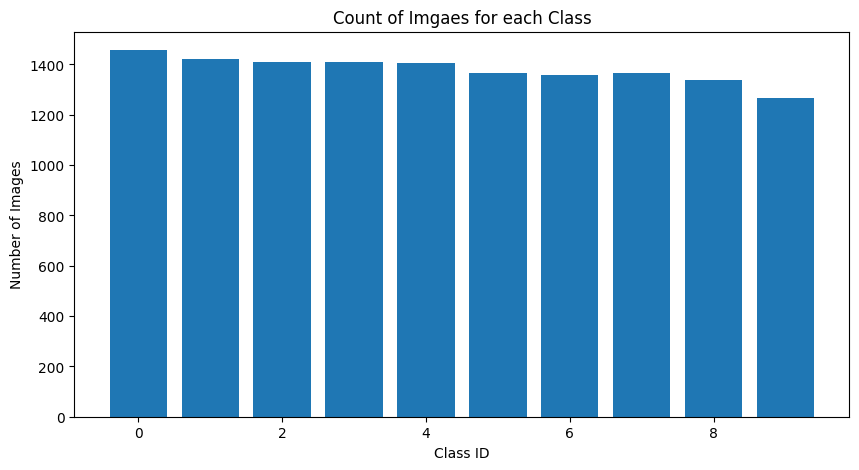

In [74]:
numOfSamples=[]
for x in range(0,noOfClasses):
    numOfSamples.append(len(np.where(y_train == x)[0]))
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses), numOfSamples)
plt.title("Count of Imgaes for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

## Preprocessing

In [86]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

#img = preProcessing(X_train[30])
#img = cv2.resize(img,(300,300))
#cv2.imshow("PreProcessed", img)
#cv2.waitKey(0)

X_train = np.array(list(map(preProcessing, X_train)))
X_test = np.array(list(map(preProcessing, X_test)))
X_validation = np.array(list(map(preProcessing, X_validation)))


In [87]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
print(X_train.shape)

(13795, 32, 32)
(13795, 32, 32, 1)


## Augumentation
Zoom, rotation, shift, translation 

In [88]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range =0.1,
                             zoom_range = 0.1,
                             shear_range = 0.1,
                             rotation_range = 10)
#we dont generate this augmented images before the training but during the training itself
dataGen.fit(X_train)

#oneHotEncode the matrices
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

In [89]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3,3)
    sizeOfPool = (2,2)
    noOfNode = 500
    
    model = Sequential()
    model.add((Conv2D(noOfFilters, sizeOfFilter1, input_shape = (imageDimensions[0],
                                                                imageDimensions[1],
                                                                1), activation='relu'
                     )))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size = sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size = sizeOfPool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation = 'softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361,490 (1.38 MB)

 Trainable params: 361,490 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
history = model.fit(dataGen.flow(X_train, y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpoch,
                                 epochs=epochsVal,
                                 validation_data = (X_validation, y_validation),
                                 shuffle = 1)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.4131 - loss: 1.6612 - val_accuracy: 0.8199 - val_loss: 0.5782
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.7626 - loss: 0.7360 - val_accuracy: 0.9058 - val_loss: 0.3057
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.8414 - loss: 0.4861 - val_accuracy: 0.9504 - val_loss: 0.1750
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.8873 - loss: 0.3587 - val_accuracy: 0.9524 - val_loss: 0.1528
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9055 - loss: 0.2994 - val_accuracy: 0.9594 - val_loss: 0.1198
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9175 - loss: 0.2620 - val_accuracy: 0.9681 - val_loss: 0.0979
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9298 - loss: 0.2275 - val_accuracy: 0.9701 - val_loss: 0.1052
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9304 -

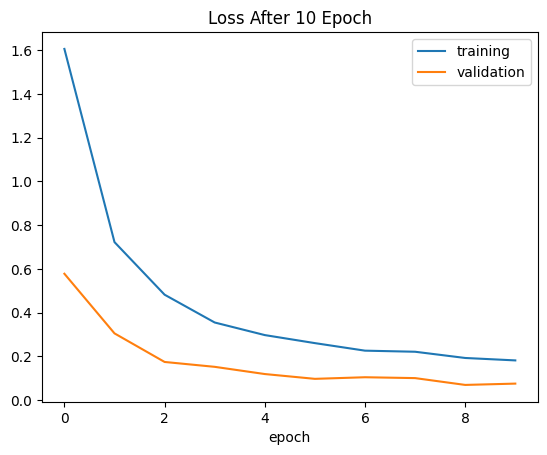

In [91]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss After 10 Epoch')
plt.xlabel('epoch')
plt.savefig('Loss_After_10Epoch')
plt.show()

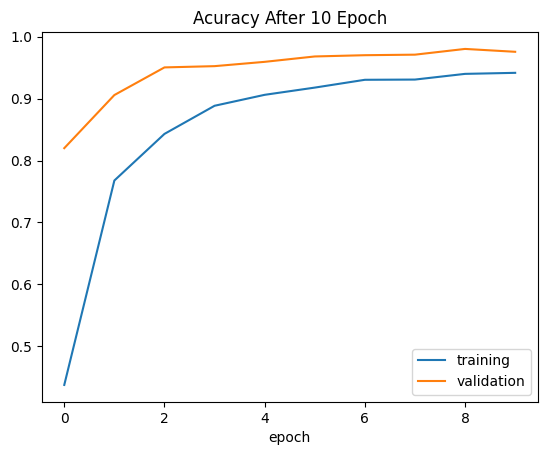

Test Score =  0.055560581386089325
Test Accuracy =  0.9821386933326721


In [92]:
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acuracy After 10 Epoch')
plt.xlabel('epoch')
plt.savefig('Accuracy_After_10Epoch')

plt.show()

score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score = ',score[0])
print('Test Accuracy = ', score[1])

In [63]:
!pip install joblib


[notice] A new release of pip is available: 23.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
model.save('model_trained.h5')

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('model_trained.h5')

# Use the model to make predictions
# Assuming you have some input data in a variable called `input_data`
predictions = model.predict(input_data)

# Print or process the predictions as needed
print(predictions)